# Seminario de Ciencia de Datos - Trabajo práctico 1
### De La Fuente, Laura - Hesse, Eugenia -  Sabrina Cervetto - Baglivo, Fabricio

#### Configuración de la carpeta de trabajo + importar librerías que serán utilizadas: numpy, scipy, matplotlib y seaborn.

In [77]:
dir_to_files = 'F:\\Cursos Doctorado\\CienciaDeDatos\\1.Estadistica'

#SET DIRECTORY
import os
os.chdir(dir_to_files)

In [78]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from  scipy import stats
%matplotlib inline
plt.rcParams.update({'figure.figsize': (10.0, 6.0), 'font.size': 24})

#LOAD FILE
file_name = 'tiempos.txt'
raw_data = np.loadtxt(file_name,skiprows=1)

## Exploración de datos y gráficos

#### Gráficos de histogramas y scatter plots de cada condición por separado.

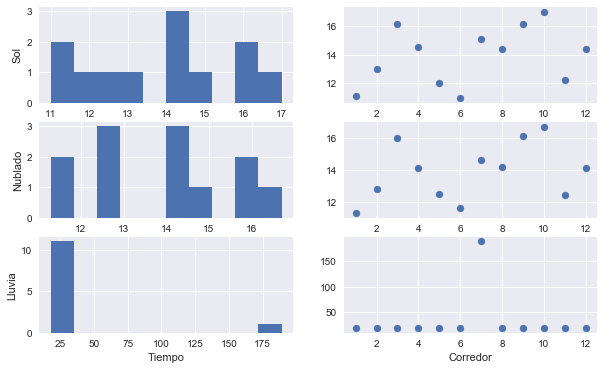

In [79]:
#INSPECCION DE DATOS CRUDOS
cond_names=["Sol","Nublado","Lluvia"]   

#SEPARADO POR CONDICION
f, axarr = plt.subplots(3, 2) 
for i in range(1,4):
    axarr[i-1,0].hist(raw_data[:,i])    
    axarr[i-1,1].scatter(raw_data[:,0],raw_data[:,i])
    axarr[i-1,0].set_ylabel(cond_names[i-1])
    
axarr[2,0].set_xlabel('Tiempo')
axarr[2,1].set_xlabel('Corredor')    

plt.show()

#### Gráficos con las condiciones superpuestas

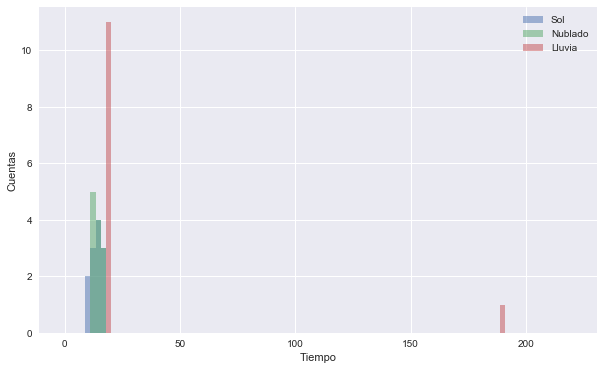

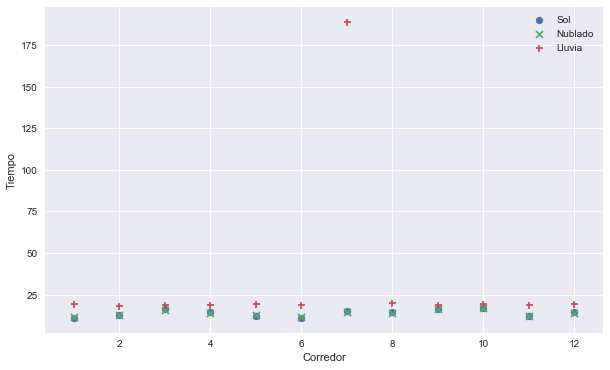

In [80]:
#VISUALIZACIÓN DATOS CRUDOS JUNTOS
bins = np.linspace(0, 220, 100)

for i in range(1,4): 
    plt.hist(raw_data[:,i],bins,alpha=0.5, label=cond_names[i-1])

plt.xlabel('Tiempo')
plt.ylabel('Cuentas') 
plt.legend(loc='upper right')
plt.show()

markers = ['o','x','+']

for i in range(1,4):     
    plt.scatter(raw_data[:,0],raw_data[:,i], label=cond_names[i-1],marker=markers[i-1])


plt.xlabel('Corredor')
plt.ylabel('Tiempo') 
plt.legend(loc='upper right')
plt.show()


## Depuración de datos

#### Los gráficos anteriores muestran un valor atípico (outlier) para la condición de lluvia. 
#### Se depuran los datos utilizando el criterio de eliminación de 2 desvíos de la media, y se reemplazan por NaN.

In [81]:
#DETECCIÓN Y ELIMINACION DE OUTLIERS
#criterio de exclusión: se eliminarán aquellos valores por arriba o por debajo de dos desvíos estándar de la media de los datos
#por condición.

data = raw_data.copy()
for nr_cond in range(1,4):
    data_cond = data[:,nr_cond].copy()
    max_threshold = np.mean(data_cond) + 2 * np.std(data_cond)
    min_threshold = np.mean(data_cond) - 2 * np.std(data_cond)
    data_cond[data[:,nr_cond]>max_threshold] = np.nan
    data_cond[data[:,nr_cond]<min_threshold] = np.nan
    data[:,nr_cond] = data_cond
    
print(data)


[[  1.   11.1  11.3  19.4]
 [  2.   13.   12.8  18.2]
 [  3.   16.1  16.   19. ]
 [  4.   14.5  14.1  18.9]
 [  5.   12.   12.5  19.1]
 [  6.   11.   11.6  18.7]
 [  7.   15.1  14.6   nan]
 [  8.   14.4  14.2  19.9]
 [  9.   16.1  16.1  18.5]
 [ 10.   17.   16.7  19.2]
 [ 11.   12.2  12.4  18.8]
 [ 12.   14.4  14.1  19.2]]


#### Graficos de datos depurados:

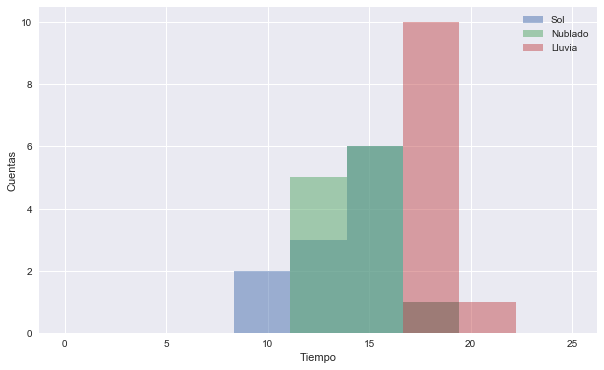

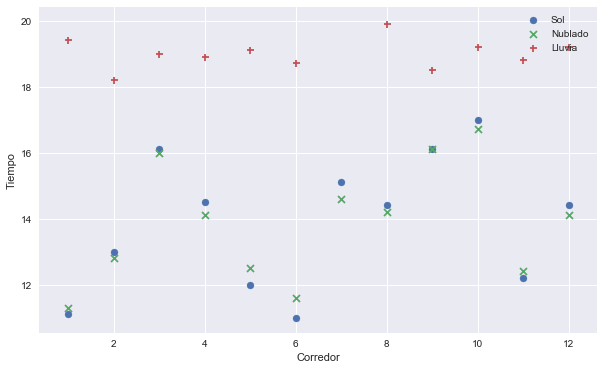

In [82]:
#VISUALIZACIÓN DATOS CURADOS, JUNTOS 
#(a partir de acá se trabajará con los datos curados solamente)
bins = np.linspace(0, 25, 10)

for i in range(1,4): 
    plt.hist(data[~np.isnan(data[:,i]),i],bins,alpha=0.5, label=cond_names[i-1])

plt.xlabel('Tiempo')
plt.ylabel('Cuentas') 
plt.legend(loc='upper right')
plt.show()

markers = ['o','x','+']

for i in range(1,4):     
    plt.scatter(data[~np.isnan(data[:,i]),0],data[~np.isnan(data[:,i]),i], label=cond_names[i-1],marker=markers[i-1])
        
plt.xlabel('Corredor')
plt.ylabel('Tiempo') 
plt.legend(loc='upper right')
plt.show()

## Pruebas de normalidad e igualdad de varianza

#### Se evalúa la normalidad de los datos utilizando las pruebas de Shapiro-Wilks.
#### Se evalúa la igualdad de varianzas de los datos utilizando la prueba de Levene.

In [83]:
#PRUEBAS DE NORMALIDAD E IGUALDAD DE VARIANZA

#Shapiro-Wilk test for normality
for i in range(1,4):         
    print(cond_names[i-1] + ": p = " + str(round(stats.shapiro(data[~np.isnan(data[:,i]),i])[0],4)) + " (Shapiro-Wilk).")    

#Levene test for equal variances
for i1 in range(1,4):
    for i2 in range(i1+1,4):
        res = stats.levene(data[~np.isnan(data[:,i1]),i1],data[~np.isnan(data[:,i2]),i2],center='mean')
        print(cond_names[i1-1] + ' vs ' + cond_names[i2-1] + ': p = ' + str(round(res[1],4)) + ' (Levene Test).')
        
     

Sol: p = 0.9382 (Shapiro-Wilk).
Nublado: p = 0.9424 (Shapiro-Wilk).
Lluvia: p = 0.9852 (Shapiro-Wilk).
Sol vs Nublado: p = 0.5247 (Levene Test).
Sol vs Lluvia: p = 0.0002 (Levene Test).
Nublado vs Lluvia: p = 0.0011 (Levene Test).


### Los resultados del test de Shapiro-Wilk no rechaza la hipótesis de normalidad de los datos para cada condición.
### Los resultados del test de Levene indican que la condición de lluvia tiene una varianza significativamente diferente a las de las otras dos condiciones.

## Implementación del test de permutaciones (y separación de datos en variables)

In [84]:
def exact_mc_perm_test2(xs, ys, nmc):
    n = len(xs)
    k=[]
    diff = np.mean(xs) - np.mean(ys)
    
    for j in range(nmc):
        zs = np.concatenate([xs, ys])
        np.random.shuffle(zs)
        k.append(np.mean(zs[:n]) - np.mean(zs[n:]))
    if diff > 0:
        return float(np.sum(k>diff))/float(nmc)
    else:
        return float(np.sum(k<diff))/float(nmc)
    
    
#datos limpios

sol_all = data[:,1].copy()
nublado_all = data[:,2].copy()
lluvia_all = data[:,3].copy() 

sol = data[~np.isnan(data[:,1]),1]
nublado = data[~np.isnan(data[:,2]),2]
lluvia = data[~np.isnan(data[:,3]),3] 

# Abordaje de preguntas

### Pregunta 1) Hipótesis: Los atletas son más lentos en días de lluvia que en días soleado.
Planteo: lluvia < sol (test de una cola) - como las varianzas son diferentes se utiliza un test no paramétrico. Se utiliza el Rank Sum Test porque es más adecuado para N < 20, si bien es para muestras independientes y los datos son dependientes.

In [85]:
#"It does not handle ties between measurements in x and y."
[tval1,pval1] = stats.ranksums(sol,lluvia)

print('Sol vs Lluvia: p=' + str(pval1)+' (Rank Sum).')
    
pperm1 = exact_mc_perm_test2(sol,lluvia, 100000) 
print('Sol vs Lluvia: p=' + str(pperm1)+ ' (permutaciones).')


Sol vs Lluvia: p=4.86500741851e-05 (Rank Sum).
Sol vs Lluvia: p=1e-05 (permutaciones).


Tanto la prueba Rank Sum como la de permutaciones rechazan la hipótesis nula (los tiempos no son distintos en días soleados y días de lluvia). Sin embargo, para poder asegurar que los atletas en días de lluvia son más lentos que en días soleados, miramos la media (mediana) y ésta debe ser mayor para los días de lluvia (más lentos).

Nota: se divide el p valor por dos, ya que el valor que devuelve la función para dos colas, y sólo una es de interés.

In [86]:
print ('Sol: media=' + str(round(np.mean(sol))) + ', mediana=' + str(round(np.median(sol))))
print ('Lluvia: media=' + str(round(np.mean(lluvia))) + ', mediana=' + str(round(np.median(lluvia))))

Sol: media=14.0, mediana=14.0
Lluvia: media=19.0, mediana=19.0


Es posible también utilizar el Welch t-test, dado que los días de sol y los de lluvia presentan varianzas distintas. Dado que es un test para muestras independientes, se realiza la resta entre condiciones y se compara con 0. Como la resta se realiza entre días de sol menos los de lluvia se espera que el estadístico sea negativo (indicando que los días de sol tienen tiempos menores a los de lluvia).

In [87]:
resta = np.subtract(sol_all,lluvia_all) 
[tval12,pval12] = stats.ttest_ind(resta,np.zeros(resta.shape),equal_var = False, nan_policy='omit')

print('Sol vs Lluvia: t=' + str(round(tval12,4)) + ', p=' + str(round(pval12,8)) + ' (Welchs Test).')

Sol vs Lluvia: t=-8.166, p=9.83e-06 (Welchs Test).


### Conclusión: En clima de lluvia los atletas son más lentos que en los días de sol.

### Pregunta 2) El cielo nublado no influye en los tiempos de los atletas.

Planteo: usamos la condición de día soleado como referencia. Dado que se cumplen los supuestos necesarios (igualdad de varianza y distribución aproximadamente normal), se realiza un t-Test para muestras pareadas.

In [88]:
# dia soleado como referencia
[tval2, pval2] = stats.ttest_rel(data[~np.isnan(data[:,1]),1],data[~np.isnan(data[:,2]),2])
print('Sol vs Nublado: p=' + str(round(pval2,4))+' (ttest_rel).')
    
pperm2=exact_mc_perm_test2(data[:,1],data[:,2], 1000)
print('Sol vs Nublado: p=' + str(pperm2)+ ' (permutaciones).')

Sol vs Nublado: p=0.6882 (ttest_rel).
Sol vs Nublado: p=0.496 (permutaciones).


### Conclusión: No hay evidencia que indique que el día nublado influye en el tiempo de los atletas respecto de los días de sol (no es posible afirmar la hipótesis nula, sólo rechazar la alternativa). 

## Pregunta 3) La velocidad en días de lluvia es independiente del atleta.
Planteo: se realizan pruebas de correlación de Pearson a fin de buscar evidencia para un modelo que muestre que el desempeño de los atletas es independiente del clima. Se espera que los atletas con buen desempeño en días soleados, también lo sean en días nublados y de lluvia.

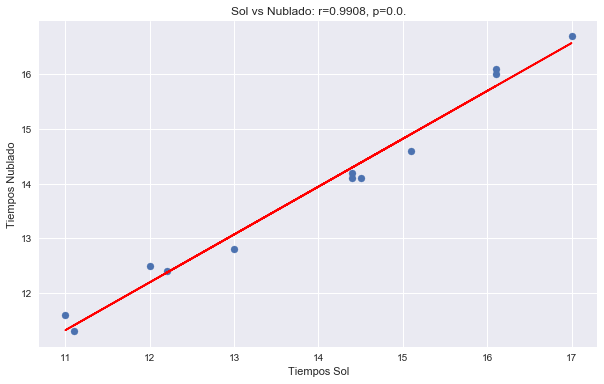

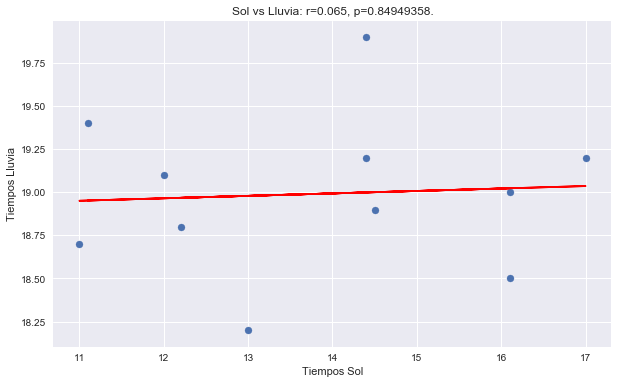

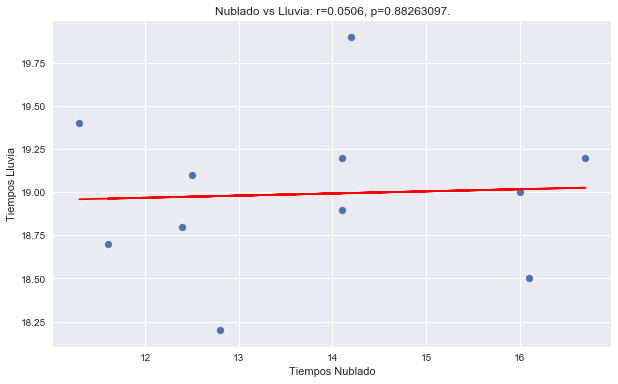

In [89]:
#Cálculo de correlaciones 
for i1 in range(1,4):
    for i2 in range(i1+1,4):
        nan_indexes = np.append(np.argwhere(np.isnan(data[:,i1])), np.argwhere(np.isnan(data[:,i2])))
        data_i1 = data[:,i1].copy()
        data_i2 = data[:,i2].copy()
        
        data_i1[nan_indexes] = np.nan 
        data_i2[nan_indexes] = np.nan 
        
        data_i1 = data_i1[~np.isnan(data_i1)]
        data_i2 = data_i2[~np.isnan(data_i2)]
        
        [r,pval] = stats.pearsonr(data_i1,data_i2)  
        
        plt.scatter(data_i1,data_i2)
        m, b = np.polyfit(data_i1,data_i2, 1)
        plt.plot(data_i1, m*data_i1 + b, 'r-')
        
        plt.title(cond_names[i1-1] + ' vs ' + cond_names[i2-1] + ': r=' +  repr(round(r,4)) + ', p=' + repr(round(pval,8)) + '.')
        plt.xlabel('Tiempos ' + cond_names[i1-1])
        plt.ylabel('Tiempos ' + cond_names[i2-1]) 
        plt.show()


### Conclusión:  Si bien la correlación es alta entre los tiempos de días de sol y nublados se encuentra que la correlación con días de lluvia es baja. La baja correlación entre variables es un indicio de independencia. Sin embargo, esto no alcanza para concluir que en días de  lluvia la velocidad es independiente de los atletas, sólo explica que el modelo de que los atletas se desempeñan igual independientemente del clima no es válido. Esto no prueba independencia entre las variables porque puede existir otro modelo de dependencia que no se está tomando en cuenta.

## Pregunta 4) El clima influye en la velocidad de los atletas.
Planteo: se realiza una prueba 1-WAY ANOVA para evaluar si hay diferencia entre los grupos, aunque los tiempos en días de lluvia tienen varianza diferente que los días de sol y nublados; además de que son datos dependientes. El test no paramétrico que quizás podría utilizarse es el de Friedman Test, pero en su implementación en la librería stats de scipy sugiere que el N > 20, y 6 medidas repetidas. Por tanto se utilizará el ANOVA.

In [90]:
#4) El clima influye en la velocidad de los atletas.

[tval4,pval4] = stats.f_oneway(sol,nublado,lluvia)

print('Anova-oneway entre climas: p=' + str(pval4))


Anova-oneway entre climas: p=3.39829804718e-09


### Conclusión: el test ANOVA muestra que existe diferencias entre los grupos por lo que podemos concluir que el clima sí influye en la velocidad de los atletas.

## ¿Qué otra conclusión obtuvo de su análisis?
En condiciones climáticas adversas la habilidad de los atletas no se ve reflejada en el desempeño.

## Consejos al Entrenador
### Los atletas sostienen que no tiene sentido entrenar con lluvia, pero el entrenador asegura que es de gran utilidad. ¿Puede a partir del análisis realizado decir quién tiene razón? En caso contrario, ¿Qué medida le sugeriría al entrenador para dirimir esta cuestión?
No se puede decir quién tiene razón. Si hubiera un efecto generado por el entrenamiento en días de lluvia, y si un grupo que entrenara en días de lluvia y otro no, luego podrian compararse los rendimientos entre ellos, por ejemplo, en un día soleado.